# Sampling Methods

## Old EM 1D code

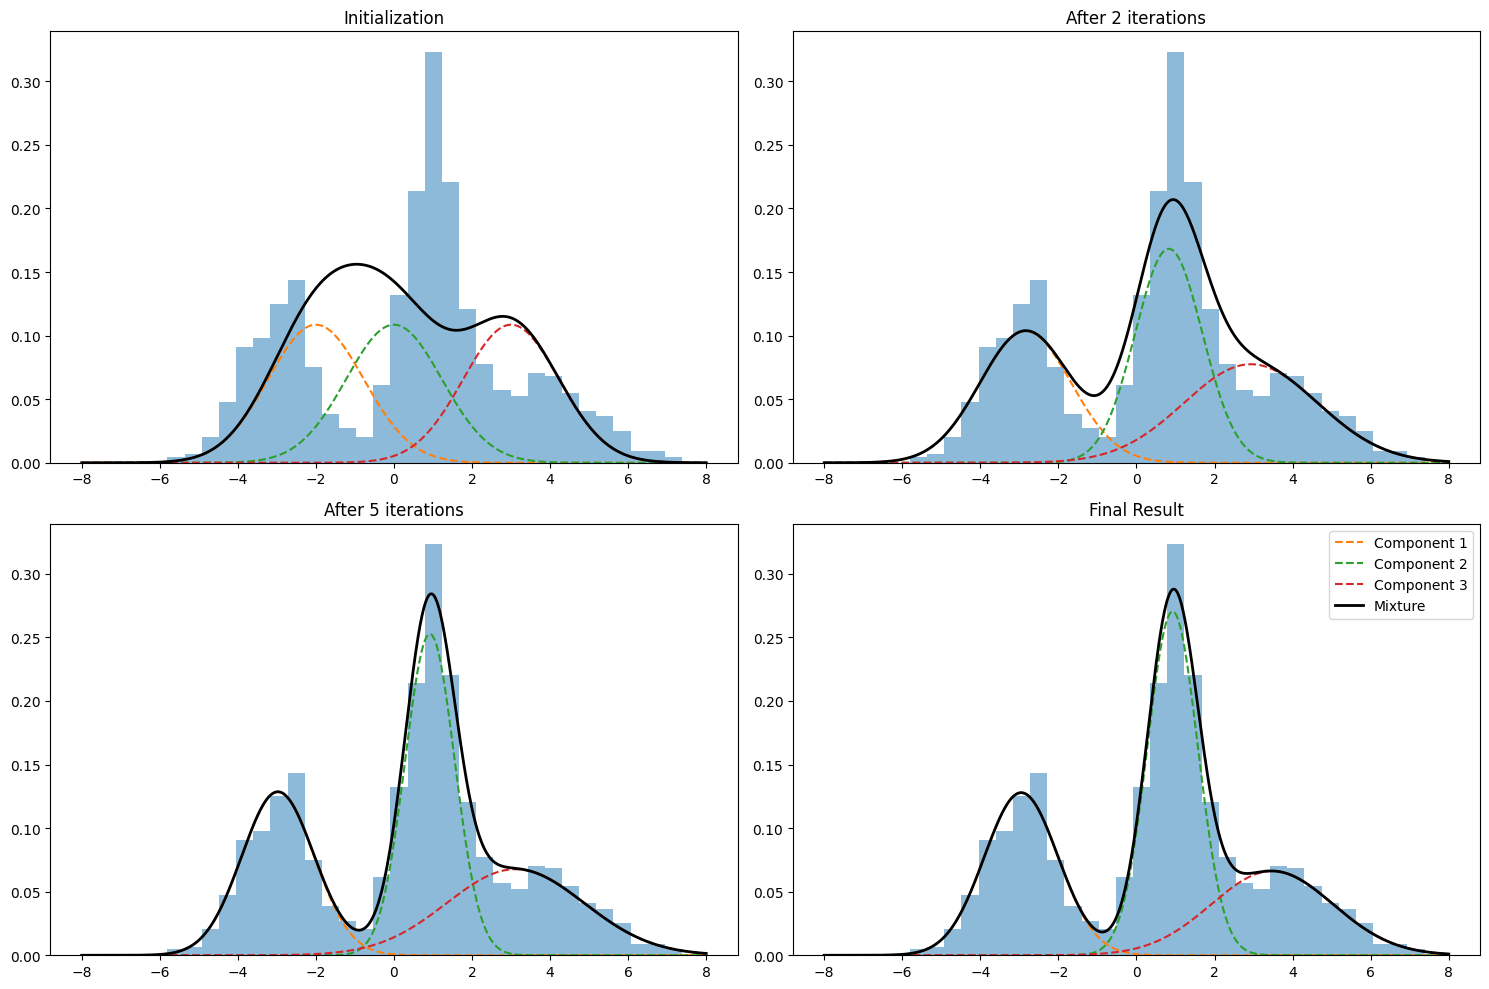

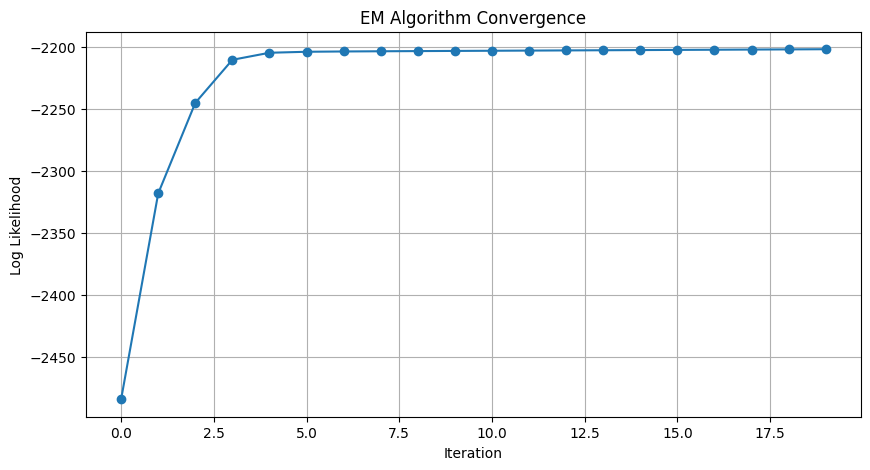

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(0)

# Parameters
K = 3  # Number of Gaussian components
N = 1000  # Number of data points
max_iter = 20  # Maximum EM iterations

# True parameters for data generation
true_means = np.array([-3, 1, 4])
true_covariances = np.array([1, 0.5, 1.5])  # variances in 1D
true_pi = np.array([0.3, 0.5, 0.2])  # mixing coefficients

# Generate synthetic data
components = np.random.choice(K, size=N, p=true_pi)
data = np.array([np.random.normal(true_means[k], np.sqrt(true_covariances[k])) for k in components])

# Initialize parameters (purposely different from true values)
means = np.array([-2, 0, 3])  # means μ_k
covariances = np.array([1.5, 1.5, 1.5])  # σ_k^2
pi = np.ones(K)/K  # uniform initial weights

# Store history for visualization
history = {'means': [means.copy()], 
           'covariances': [covariances.copy()], 
           'pi': [pi.copy()],
           'log_likelihood': []}

# EM Algorithm
for iteration in range(max_iter):
    # E-step: Compute responsibilities γ(z_nk) - Equation 1
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * norm.pdf(data, means[k], np.sqrt(covariances[k]))
    gamma /= gamma.sum(axis=1, keepdims=True)  # normalize
    
    # M-step: Update parameters - Equations 2-5
    Nk = gamma.sum(axis=0)  # Equation 5
    
    # Update means - Equation 2
    new_means = np.array([np.sum(gamma[:, k] * data) / Nk[k] for k in range(K)])
    
    # Update covariances - Equation 3 (simplified for 1D)
    new_covariances = np.array([np.sum(gamma[:, k] * (data - new_means[k])**2) / Nk[k] for k in range(K)])
    
    # Update mixing coefficients - Equation 4
    new_pi = Nk / N
    
    # Compute log likelihood - Equation 6
    log_likelihood = np.sum([np.log(np.sum([pi[k] * norm.pdf(x, means[k], np.sqrt(covariances[k])) 
                                          for k in range(K)])) for x in data])
    
    # Store current parameters
    history['means'].append(new_means.copy())
    history['covariances'].append(new_covariances.copy())
    history['pi'].append(new_pi.copy())
    history['log_likelihood'].append(log_likelihood)
    
    # Update parameters for next iteration
    means, covariances, pi = new_means, new_covariances, new_pi

# Visualization
plt.figure(figsize=(15, 10))

# Plot initialization
plt.subplot(2, 2, 1)
x_grid = np.linspace(-8, 8, 1000)
init_means = history['means'][0]
init_covs = history['covariances'][0]
init_pi = history['pi'][0]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = init_pi[k] * norm.pdf(x_grid, init_means[k], np.sqrt(init_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('Initialization')

# Plot after 2 iterations
plt.subplot(2, 2, 2)
iter2_means = history['means'][2]
iter2_covs = history['covariances'][2]
iter2_pi = history['pi'][2]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter2_pi[k] * norm.pdf(x_grid, iter2_means[k], np.sqrt(iter2_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 2 iterations')

# Plot after 5 iterations
plt.subplot(2, 2, 3)
iter5_means = history['means'][5]
iter5_covs = history['covariances'][5]
iter5_pi = history['pi'][5]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter5_pi[k] * norm.pdf(x_grid, iter5_means[k], np.sqrt(iter5_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 5 iterations')

# Plot final result
plt.subplot(2, 2, 4)
final_means = history['means'][-1]
final_covs = history['covariances'][-1]
final_pi = history['pi'][-1]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = final_pi[k] * norm.pdf(x_grid, final_means[k], np.sqrt(final_covs[k]))
    plt.plot(x_grid, component, '--', label=f'Component {k+1}')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2, label='Mixture')
plt.title('Final Result')
#sorry keene idk why the legend only shows in the bottom left histogram. idk how to fix it
plt.legend()

plt.tight_layout()
plt.show()

# Plot log likelihood
plt.figure(figsize=(10, 5))
plt.plot(history['log_likelihood'], 'o-')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

## Rejection Sampling GMM

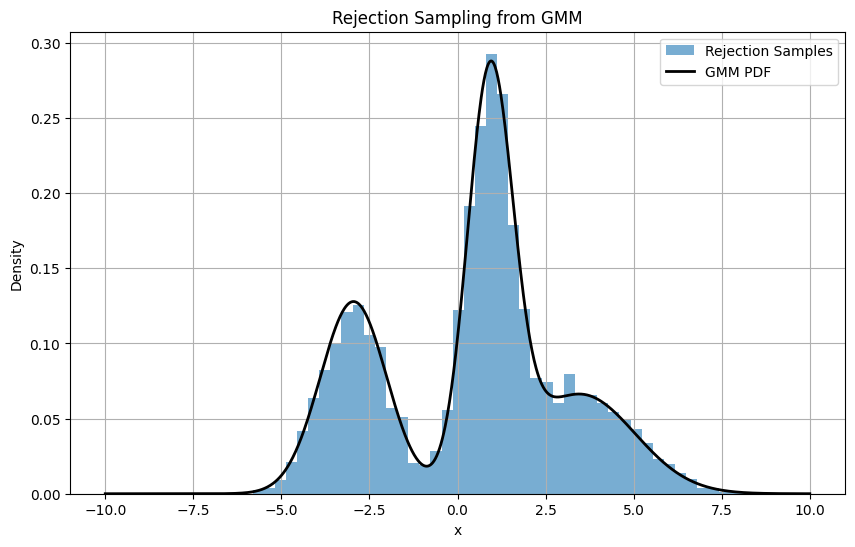

In [8]:
gmm_means = final_means
gmm_stds = np.sqrt(final_covs)
gmm_weights = final_pi

# Define target GMM density function
def gmm_pdf(x):
    return sum(w * norm.pdf(x, mu, std) for w, mu, std in zip(gmm_weights, gmm_means, gmm_stds))

# Define proposal distribution (standard normal, or wider for more coverage)
proposal_mean = 0
proposal_std = 4  # Make it wide enough to cover the GMM support
proposal_pdf = lambda x: norm.pdf(x, proposal_mean, proposal_std)
proposal_sampler = lambda size: np.random.normal(proposal_mean, proposal_std, size)

# Estimate M: the max of target(x) / proposal(x)
x_vals = np.linspace(-10, 10, 1000)
ratios = [gmm_pdf(x) / proposal_pdf(x) for x in x_vals]
M = max(ratios) * 1.1  # add buffer to ensure envelope

# Rejection sampling
num_samples = 10000
samples = []
while len(samples) < num_samples:
    x = proposal_sampler(1)[0]
    u = np.random.uniform(0, M * proposal_pdf(x))
    if u <= gmm_pdf(x):
        samples.append(x)

samples = np.array(samples)

# Plot the histogram of samples with GMM overlay
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Rejection Samples')
x_grid = np.linspace(-10, 10, 1000)
pdf = np.array([gmm_pdf(x) for x in x_grid])
plt.plot(x_grid, pdf, 'k-', lw=2, label='GMM PDF')
plt.title("Rejection Sampling from GMM")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## Linear Regression with MCMC

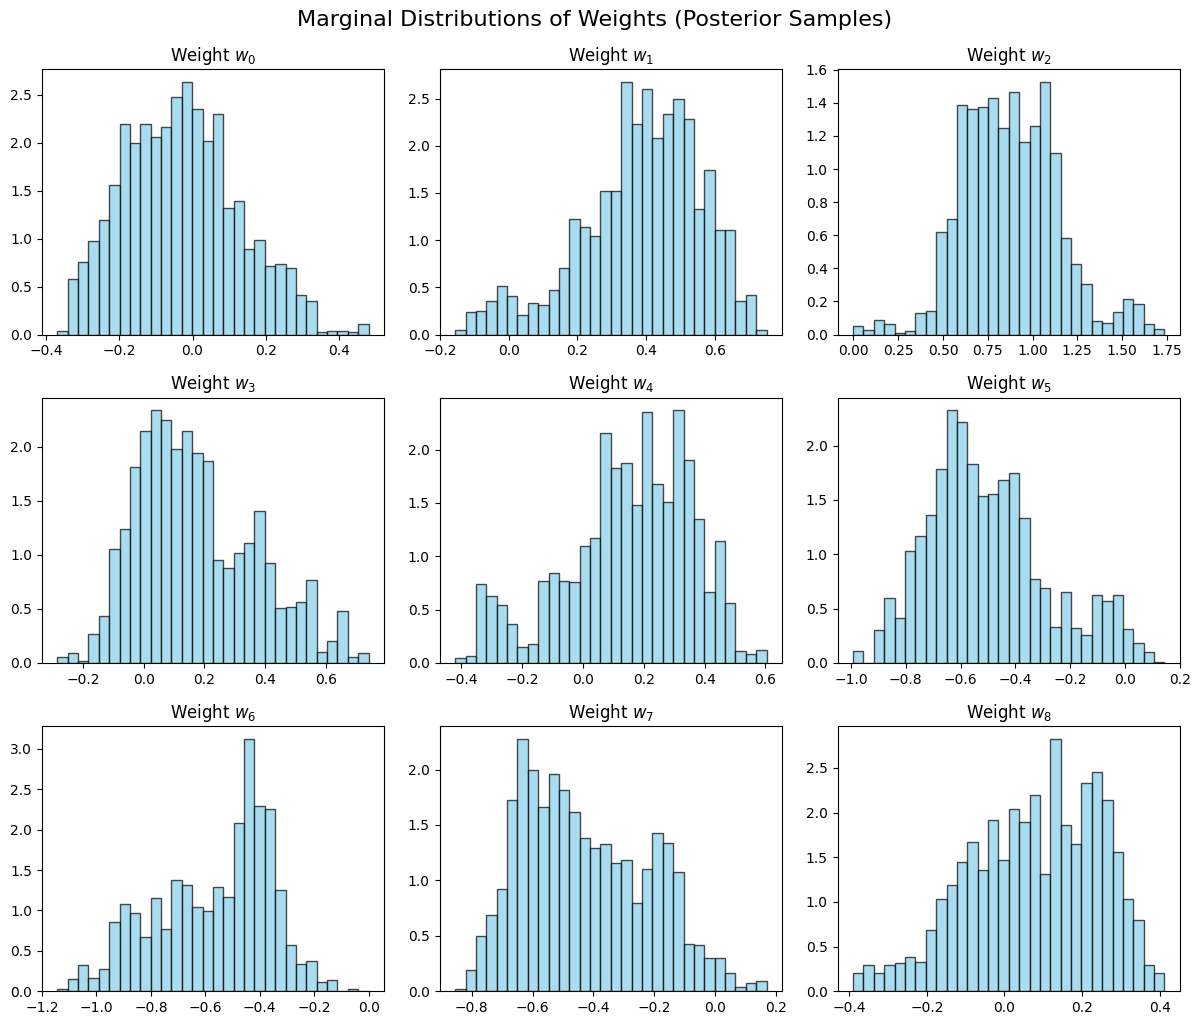

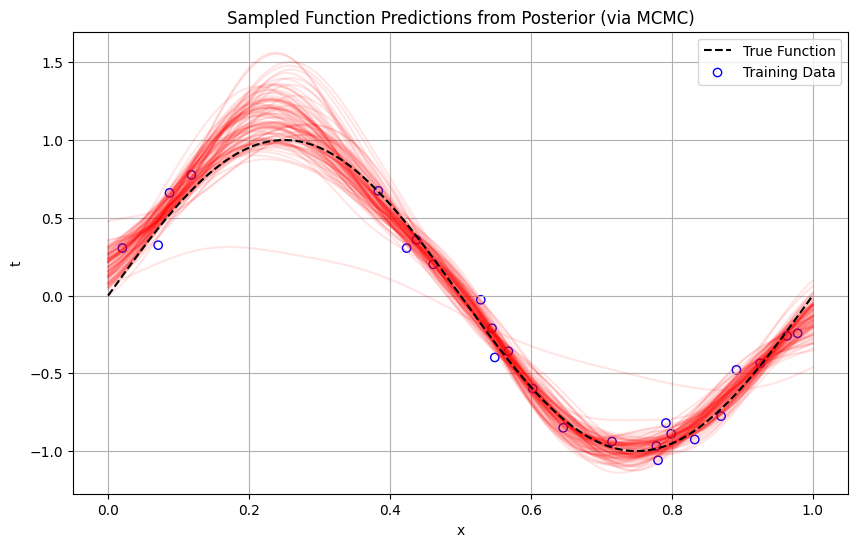

In [9]:
# Basis function setup (from project 2)
def design_matrix(x, centers, width):
    return np.exp(-0.5 * ((x[:, None] - centers[None, :]) / width)**2)

# True function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Generate training data
np.random.seed(0)
N = 25
x_train = np.random.uniform(0, 1, N)
t_train = true_function(x_train) + np.random.normal(0, 0.1, N)  # noise std = 0.1

# Create design matrix for training data
num_basis = 9
centers = np.linspace(0, 1, num_basis)
width = 0.1
Phi = design_matrix(x_train, centers, width)

# Likelihood and prior setup
beta = 1 / 0.1**2  # Precision of likelihood (inverse of noise variance)
alpha = 1.0        # Precision of prior
prior_mean = np.zeros(num_basis)
prior_cov = np.eye(num_basis) / alpha

# Log posterior function (unnormalized)
def log_posterior(w, Phi, t, beta, alpha):
    # Log likelihood
    y = Phi @ w
    log_likelihood = -0.5 * beta * np.sum((t - y) ** 2)
    # Log prior
    log_prior = -0.5 * alpha * np.sum(w ** 2)
    return log_likelihood + log_prior

# Metropolis sampler
def metropolis_sampler(log_posterior, initial_w, Phi, t, beta, alpha, num_samples=5000, proposal_std=0.05):
    w_current = initial_w.copy()
    logp_current = log_posterior(w_current, Phi, t, beta, alpha)
    samples = [w_current.copy()]
    accept_count = 0

    for _ in range(num_samples):
        w_proposal = w_current + np.random.normal(0, proposal_std, size=w_current.shape)
        logp_proposal = log_posterior(w_proposal, Phi, t, beta, alpha)

        # Acceptance probability
        acceptance_ratio = np.exp(logp_proposal - logp_current)
        if np.random.rand() < min(1, acceptance_ratio):
            w_current = w_proposal
            logp_current = logp_proposal
            accept_count += 1
        samples.append(w_current.copy())

    return np.array(samples), accept_count / num_samples

# Run Metropolis sampling
initial_w = np.zeros(num_basis)
samples, acceptance_rate = metropolis_sampler(log_posterior, initial_w, Phi, t_train, beta, alpha)

samples.shape, acceptance_rate

#plot
# Plot marginal histograms for each weight
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in range(num_basis):
    ax = axs[i // 3, i % 3]
    ax.hist(samples[:, i], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='k')
    ax.set_title(f'Weight $w_{i}$')
plt.tight_layout()
plt.suptitle("Marginal Distributions of Weights (Posterior Samples)", fontsize=16, y=1.02)
plt.show()

# Plot sampled functions using posterior weight samples
x_test = np.linspace(0, 1, 200)
Phi_test = design_matrix(x_test, centers, width)

plt.figure(figsize=(10, 6))
for i in range(100):  # plot 100 sampled functions
    w_sample = samples[np.random.randint(0, samples.shape[0])]
    y_pred = Phi_test @ w_sample
    plt.plot(x_test, y_pred, color='red', alpha=0.1)

# Plot the true function and training data
plt.plot(x_test, true_function(x_test), 'k--', label='True Function')
plt.scatter(x_train, t_train, edgecolor='b', facecolor='none', label='Training Data')
plt.title("Sampled Function Predictions from Posterior (via MCMC)")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.grid(True)
plt.show()


# Stretch Goal

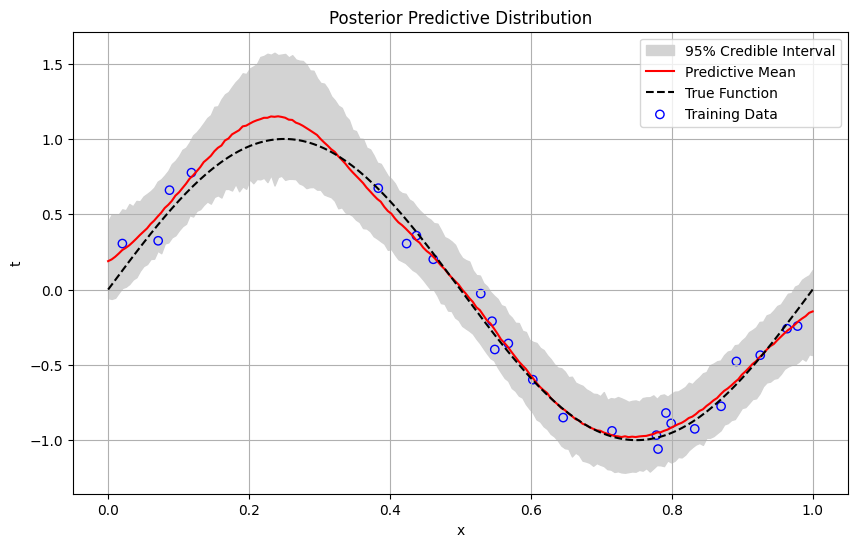

In [13]:
# Generate test design matrix
x_test = np.linspace(0, 1, 200)
Phi_test = design_matrix(x_test, centers, width)

# Draw predictive samples(learned from the stack exchange)
num_samples_from_posterior = 1000
predictive_samples = []

for w in samples[np.random.choice(len(samples), num_samples_from_posterior, replace=False)]:
    mean = Phi_test @ w
    noisy_sample = mean + np.random.normal(0, np.sqrt(1 / beta), size=mean.shape)
    predictive_samples.append(noisy_sample)

predictive_samples = np.array(predictive_samples)

# Compute predictive mean and 95% credible interval
predictive_mean = np.mean(predictive_samples, axis=0)
lower_bound = np.percentile(predictive_samples, 2.5, axis=0)
upper_bound = np.percentile(predictive_samples, 97.5, axis=0)

# Plot the predictive distribution
plt.figure(figsize=(10, 6))
plt.fill_between(x_test, lower_bound, upper_bound, color='lightgray', label='95% Credible Interval')
plt.plot(x_test, predictive_mean, 'r-', label='Predictive Mean')
plt.plot(x_test, true_function(x_test), 'k--', label='True Function')
plt.scatter(x_train, t_train, facecolor='none', edgecolor='b', label='Training Data')
plt.title("Posterior Predictive Distribution")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.grid(True)
plt.show()
